# Term Project : Game Rating Predictor

<b> Name:</b> Jemis Dhameliya<br>
<b> ID:</b> 1001773032

## Overview

- 1.Read the data from dataset
- 2.Preprocess the data
    - 2.1 Remove empty rows(comment)
    - 2.2 Remove Alphanumeric values from comment
    - 2.3 Remove Stopwords from data
- 3.Divide dataset into training and testing
- 4.Vectorize the data
- 5.Classify data with different Classifier
    - 5.1 Find Accuracy
    - 5.2 Find RMSE
- 6.HyperParameter Tuning
    - 6.1 Test the Model using HyperParameter

## Classifier

### Multinomial Naive Bayes
The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.<br>
<b>Posterior Probability = (Prior * Likelihood)/(Evidence)</b><br>
Multinomial Naive Bayes calculates likelihood to be count of an word/token (random variable).

### Ridge Classifier
This classifier first converts the target values into {-1, 1} and then treats the problem as a regression task (multi-output regression in the multiclass case).The highest value in prediction is accepted as a target class and for multiclass data muilti-output regression is applied.

### Logistic Regression
Logistic regression, despite its name, is a classification algorithm rather than regression algorithm. Based on a given set of independent variables, it is used to estimate discrete value (0 or 1, yes/no, true/false). It is also called logit or MaxEnt Classifier.<br>
Basically, it measures the relationship between the categorical dependent variable and one or more independent variables by estimating the probability of occurrence of an event using its logistics function.

In [1]:
import re
import os
import csv
import random
import pickle
import joblib
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import nltk

### -->> Read the dataset

#### I used board greek game review dataset,which has around 15 million review(comment). Each user has give rating to game on the scale of 10.

In [2]:
review_data = r'D:\DMproject\bgg-15m-reviews.csv'

In [3]:
data=pd.read_csv(review_data)
#data.head()

In [4]:
data.head()

,Unnamed: 0,user,rating,comment,ID,name
0,0,Torsten,10.0,NaN,30549,Pandemic
1,1,mitnachtKAUBO-I,10.0,Hands down my favorite new game of BGG CON 200...,30549,Pandemic
2,2,avlawn,10.0,I tend to either love or easily tire of co-op ...,30549,Pandemic
3,3,Mike Mayer,10.0,NaN,30549,Pandemic
4,4,Mease19,10.0,This is an amazing co-op game. I play mostly ...,30549,Pandemic


In [5]:
data.tail()

,Unnamed: 0,user,rating,comment,ID,name
15823264,15823264,Fafhrd65,8.0,Turn based preview looks very promising. The g...,281515,Company of Heroes
15823265,15823265,PlatinumOh,8.0,KS,281515,Company of Heroes
15823266,15823266,BunkerBill,7.0,NaN,281515,Company of Heroes
15823267,15823267,Hattori Hanzo,6.0,NaN,281515,Company of Heroes
15823268,15823268,Richie2000,1.0,NaN,281515,Company of Heroes


In [6]:
data.isna().sum()

Unnamed: 0           0
user                66
rating               0
comment       12828246
ID                   0
name                 0
dtype: int64

In [7]:
len(data)

15823269

### Remove the empty Value

-->> There are many comments that have empty values. We don't need this empty values for our classification beacuse that does not help us for any prediction.

In [8]:
data = data[['comment','rating']]
#removing missing values from datafra
data.dropna(inplace=True)
print("Length of dataset after removing missing values: ",len(data))
print('')
data.head()

Length of dataset after removing missing values:  2995023



,comment,rating
1,Hands down my favorite new game of BGG CON 200...,10.0
2,I tend to either love or easily tire of co-op ...,10.0
4,This is an amazing co-op game. I play mostly ...,10.0
5,Hey! I can finally rate this game I've been pl...,10.0
8,Love it- great fun with my son. 2 plays so far...,10.0


In [9]:
len(data)

2995023

In [10]:
X=data.iloc[:,0].values

In [11]:
X[2]

"This is an amazing co-op game.  I play mostly with my wife and this is a game that I can't really imagine getting tired of.  Win or lose, I usually want to play again immediately.  On the Brink and the fan-made expansion from on ArtsCow add much more variety and good game play, only enhancing an already great game."

### Preprocess the Data

Preprocess tha data needed beacuse to get some meaningful information and improve performance.

->Remove any alphanumeric values and also remove html tags and sigle letter words.

->Convert all letters to lower case.

In [12]:
P1 = re.compile("(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)")
P2 = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
def preprocess(text):
    text = re.sub(P2, '' , str(text))
    text = re.sub(P1, ' ',str(text))
    text = re.sub('[^a-zA-Z]', ' ', str(text))
    text = text.lower()
    return text

for i in range(len(X)):
    X[i] = preprocess(X[i])
X[2]

'this is an amazing coop game    play mostly with my wife and this is  game that  can  really imagine getting tired of   win or lose   usually want to play again immediately   on the brink and the fanmade expansion from on artscow add much more variety and good game play  only enhancing an already great game '

#### Considering the limitation of processor and system, I take small size of data for further process. So I take around 5% of total data for further classification.

In [14]:
shuffle = data.sample(frac=1).to_numpy() 
size = int(0.05*len(data))
small_chunk = shuffle[:size]
print("Size of training set: ",len(small_chunk))

Size of training set:  149751


In [15]:
small_chunk[:5]

array([['this game is fun ', 5.0],
       ['players     time    hrs you must solve  series of riddles and puzzles to escape from  room  each correct solution brings you to another riddle  how fast can you escape the room  this game can be played only once  because you markup  fold  and tear the game materials ',
        7.5],
       [' redniak plus za piwo', 5.0],
       ['very good strategic game  pocket  easy to carry and to play ',
        7.0],
       ['it is fine   brittny is  huge fan  but  feel something is lacking ',
        5.0]], dtype=object)

In [16]:
chunk_C=small_chunk[:,0]

In [17]:
chunk_C[2]

' redniak plus za piwo'

In [18]:
dataset=pd.DataFrame({'comment':small_chunk[:,0],'rating':small_chunk[:,1]})
dataset.head()

,comment,rating
0,this game is fun,5
1,players time hrs you must solve series...,7.5
2,redniak plus za piwo,5
3,very good strategic game pocket easy to carr...,7
4,it is fine brittny is huge fan but feel s...,5


#### Remove Stop Words:

Comments still have stopwords in it and that has to be removed.
So I tokenize all comments and then remove stopwords using nltk.

In [19]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
dataset['comment'] = dataset['comment'].apply(lambda x: tokenizer.tokenize(x.lower()))
dataset.head()

,comment,rating
0,"[this, game, is, fun]",5
1,"[players, time, hrs, you, must, solve, series,...",7.5
2,"[redniak, plus, za, piwo]",5
3,"[very, good, strategic, game, pocket, easy, to...",7
4,"[it, is, fine, brittny, is, huge, fan, but, fe...",5


In [20]:
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to C:\Users\Dhameliya
[nltk_data]     Jemis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Dhameliya
[nltk_data]     Jemis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
stops = set(stopwords.words("english"))
dataset['comment'] = dataset['comment'].apply(lambda x: [item for item in x if item not in stops])
dataset.head()

,comment,rating
0,"[game, fun]",5
1,"[players, time, hrs, must, solve, series, ridd...",7.5
2,"[redniak, plus, za, piwo]",5
3,"[good, strategic, game, pocket, easy, carry, p...",7
4,"[fine, brittny, huge, fan, feel, something, la...",5


In [22]:
dataset['comment'] = dataset['comment'].apply(' '.join)
dataset.head(10)

,comment,rating
0,game fun,5
1,players time hrs must solve series riddles puz...,7.5
2,redniak plus za piwo,5
3,good strategic game pocket easy carry play,7
4,fine brittny huge fan feel something lacking,5
5,marvel legendary replaced,6
6,gencon,5
7,rdekes hogy ez volt az els j k gipf univerzumb...,7.5
8,congressman joe wilson favorite game,6
9,dry abstract game take long get excited playin...,5


#### Top 10 most used words.

In [23]:
print(Counter(' '.join(dataset["comment"]).split()).most_common(10)[:10])

[('game', 142717), ('play', 41336), ('like', 28907), ('fun', 28754), ('one', 26604), ('good', 22067), ('games', 21553), ('really', 20270), ('players', 20244), ('played', 19643)]


#### There are many distinct values of rating and with that much of different values it is very tough to predict the rating. So I used round method to roundof the values of rating. EXP: 7.4=7.0

In [24]:
dataset['rating'] =np.round(dataset['rating'].astype(np.double))
dataset.head(10)

,comment,rating
0,game fun,5.0
1,players time hrs must solve series riddles puz...,8.0
2,redniak plus za piwo,5.0
3,good strategic game pocket easy carry play,7.0
4,fine brittny huge fan feel something lacking,5.0
5,marvel legendary replaced,6.0
6,gencon,5.0
7,rdekes hogy ez volt az els j k gipf univerzumb...,8.0
8,congressman joe wilson favorite game,6.0
9,dry abstract game take long get excited playin...,5.0


In [25]:
dataset['rating'].value_counts()

8.0     37695
7.0     32346
6.0     29677
9.0     13821
5.0     12095
10.0     9250
4.0      7612
3.0      3877
2.0      2217
1.0      1161
Name: rating, dtype: int64

#### Now, Divide the dataset into two parts: 1. Features and 2. Lables

I used train_test_split method for divide the dataset. 

70% of dataset is used for train and 30% of dataset is used for testing.

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(dataset['comment'], dataset['rating'], test_size=0.3)
print(len(X_train))
print(len(X_test))
print(len(Y_train))
print(len(Y_test))

104825
44926
104825
44926


### Vectorizing The data.

<b>CountVectorizer()</b> : Scikit-learn’s CountVectorizer is used to convert a collection of text documents to a vector of term/token counts. It also enables the pre-processing of text data prior to generating the vector representation. This functionality makes it a highly flexible feature representation module for text.

fit_transform() : Learn the vocabulary dictionary and return document-term matrix

transform() : Transform documents to document-term matrix.

get_feature_names() : Array mapping from feature integer indices to feature name.

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5).fit(X_train)
pred = vectorizer.fit_transform(X_train)
pred1 = vectorizer.transform(X_test)
print("pred:\n{}".format(repr(pred)))

pred:
<104825x17008 sparse matrix of type '<class 'numpy.int64'>'
	with 1759545 stored elements in Compressed Sparse Row format>


In [28]:
feature_names = vectorizer.get_feature_names()
print("Number of features: {}".format(len(feature_names)))

Number of features: 17008


# Classifier :

## Multinomial Naive Bayes

alpha : Laplace smoothing parameter. I have used alpha=0.01

fit(x,y) : Fit Naive Bayes classifier according to x,y

predict(x) : Perform classification on an array of test vectors x. test vectors= X_test

In [29]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB(alpha=.01)
mnb.fit(pred, Y_train)

MultinomialNB(alpha=0.01)

In [30]:
result = mnb.predict(pred1)
#type(result)
result[:5]

array([ 6.,  8.,  8.,  7., 10.])

<b>Accuracy_score(x,y)</b> : This function computes subset accuracy. The set of labels predicted for a sample must exactly match the corresponding set of labels in True class. 

<b>mean_squared_error(x,y)</b> : This function calculates the mean square error.

<b>classifiction_report(x,y)</b> : Build a text report showing the main classification metrics. That includes precision, f1-score,recall,supoort,accuracy.

<b>True class</b>:- Y_test and <b>predicted samples</b>:- result

In [86]:
from sklearn.metrics import accuracy_score,mean_squared_error,classification_report
mnb_score = accuracy_score(Y_test, result)
mnb_rmse = mean_squared_error(Y_test, result)
print("Accuracy:   {:.5f}".format(mnb_score))
print("MSE:   {:.5f}".format(mnb_rmse))
print("Classification Report for Multinomial Naive Bayes:\n", classification_report(Y_test,result))

Accuracy:   0.28916
MSE:   3.14746
Classification Report for Multinomial Naive Bayes:
               precision    recall  f1-score   support

         1.0       0.13      0.09      0.10       338
         2.0       0.13      0.08      0.10       659
         3.0       0.12      0.06      0.08      1147
         4.0       0.18      0.10      0.13      2319
         5.0       0.19      0.15      0.16      3579
         6.0       0.29      0.30      0.30      8867
         7.0       0.29      0.26      0.27      9727
         8.0       0.34      0.51      0.40     11339
         9.0       0.20      0.11      0.15      4155
        10.0       0.27      0.24      0.26      2796

    accuracy                           0.29     44926
   macro avg       0.22      0.19      0.20     44926
weighted avg       0.27      0.29      0.27     44926



In [32]:
print("Training set score: {:.5f}".format(mnb.score(pred, Y_train)))
print("Test set score: {:.5f}".format(mnb.score(pred1, Y_test)))

Training set score: 0.45507
Test set score: 0.28916


Populating the interactive namespace from numpy and matplotlib


C:\Users\Dhameliya Jemis\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random', 'shuffle', 'datetime', 'size']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


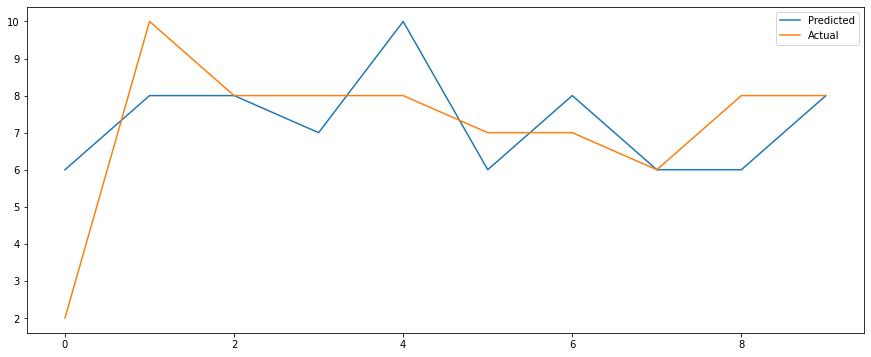

In [33]:
%pylab inline 
pylab.rcParams['figure.figsize'] = (15,6)
plt.plot(result[:10],label = 'Predicted')
plt.plot(Y_test[:10].values, label = 'Actual')

plt.legend()
plt.show()

<b> GridsearchCV </b>
I used GridsearhCV to get better result.Exhaustive search over specified parameter values for an estimator.<br>
<b>param_grid:</b>Dictionary with parameters names (str) as keys and lists of parameter settings to try as values, or a list of such dictionaries, in which case the grids spanned by each dictionary in the list are explored. This enables searching over any sequence of parameter settings.<br>
<b>n_jobsint: </b>Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details.<br>
<b>verboseinteger :</b>Controls the verbosity: the higher, the more messages.

In [100]:
from sklearn.model_selection import GridSearchCV

params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],}

mnb_grid = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
mnb_grid.fit(pred,Y_train)

print('Train Accuracy : %.3f'%mnb_grid.best_estimator_.score(pred, Y_train))
print('Test Accuracy : %.3f'%mnb_grid.best_estimator_.score(pred1, Y_test))
print('Best Accuracy Through Grid Search : %.3f'%mnb_grid.best_score_)
print('Best Parameters : ',mnb_grid.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.7s finished


Train Accuracy : 0.345
Test Accuracy : 0.303
Best Accuracy Through Grid Search : 0.297
Best Parameters :  {'alpha': 10.0}


Tf-idf stands for term frequency-inverse document frequency,This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction.

Count Vectorizer give number of frequency with respect to index of vocabulary where as tf-idf consider overall documents of weight of words.

<b>TfidfVectorizer()</b> :  TfidfVectorizer weights the word counts by a measure of how often they appear in the documents.

<b>Tfidfvectorizer() gives better accuracy and effectiveness of vectors on model.</b>

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=5).fit(X_train)
predtf = tfidfvectorizer.transform(X_train)
predtf1 = tfidfvectorizer.transform(X_test)
#print("predtf:\n{}".format(repr(predtf)))

<b> Multinomial Naive Bayes with tfidf </b><br>
It gives better accuracy compare to vectorizer.

In [46]:
result1 = mnb.predict(predtf1)
result1[:5]

array([6., 8., 8., 7., 8.])

In [87]:
mnb_score2 = accuracy_score(Y_test, result1)
mnb_rmse2 = mean_squared_error(Y_test, result1)
print("Accuracy:   {:.5f}".format(mnb_score2))
print("MSE:   {:.5f}".format(mnb_rmse2))
print("Classification Report for Multinomial Naive Bayes with tfidf:\n", classification_report(Y_test,result1))

Accuracy:   0.29259
MSE:   3.02903
Classification Report for Multinomial Naive Bayes with tfidf:
               precision    recall  f1-score   support

         1.0       0.21      0.02      0.03       338
         2.0       0.19      0.01      0.02       659
         3.0       0.17      0.01      0.01      1147
         4.0       0.27      0.02      0.04      2319
         5.0       0.20      0.03      0.05      3579
         6.0       0.28      0.32      0.30      8867
         7.0       0.26      0.24      0.25      9727
         8.0       0.31      0.67      0.42     11339
         9.0       0.25      0.03      0.05      4155
        10.0       0.39      0.05      0.09      2796

    accuracy                           0.29     44926
   macro avg       0.25      0.14      0.13     44926
weighted avg       0.28      0.29      0.24     44926



In [48]:
print("Training set score: {:.5f}".format(mnb.score(predtf, Y_train)))
print("Test set score: {:.5f}".format(mnb.score(predtf1, Y_test)))

Training set score: 0.42071
Test set score: 0.29259


Populating the interactive namespace from numpy and matplotlib


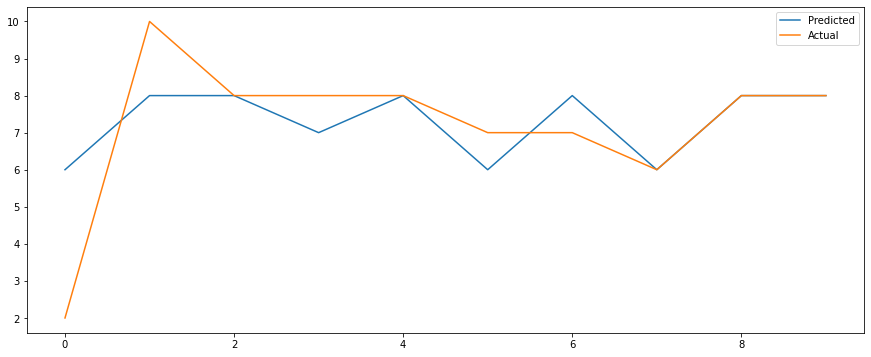

In [49]:
%pylab inline 
pylab.rcParams['figure.figsize'] = (15,6)
plt.plot(result1[:10],label = 'Predicted')
plt.plot(Y_test[:10].values, label = 'Actual')

plt.legend()
plt.show()

## <b> Ridge Classifier </b>

In [50]:
from sklearn.linear_model import RidgeClassifier
ridge=RidgeClassifier().fit(pred,Y_train)

In [51]:
result3=ridge.predict(pred1)
result3[:5]

array([ 6., 10.,  8.,  8.,  8.])

In [88]:
ridge_score = accuracy_score(Y_test, result3)
ridge_rmse = mean_squared_error(Y_test, result3)
print("Accuracy:   {:.5f}".format(ridge_score))
print("MSE:   {:.5f}".format(ridge_rmse))
print("Classification Report for Ridge Classifier:\n", classification_report(Y_test,result3))

Accuracy:   0.28244
MSE:   3.28026
Classification Report for Ridge Classifier:
               precision    recall  f1-score   support

         1.0       0.33      0.03      0.06       338
         2.0       0.17      0.02      0.04       659
         3.0       0.18      0.02      0.04      1147
         4.0       0.16      0.05      0.07      2319
         5.0       0.18      0.06      0.09      3579
         6.0       0.28      0.31      0.29      8867
         7.0       0.26      0.28      0.27      9727
         8.0       0.31      0.55      0.40     11339
         9.0       0.18      0.07      0.10      4155
        10.0       0.30      0.12      0.17      2796

    accuracy                           0.28     44926
   macro avg       0.24      0.15      0.15     44926
weighted avg       0.26      0.28      0.25     44926



In [53]:
print("Training set score: {:.5f}".format(ridge.score(pred, Y_train)))
print("Test set score: {:.5f}".format(ridge.score(pred1, Y_test)))

Training set score: 0.49342
Test set score: 0.28244


Populating the interactive namespace from numpy and matplotlib


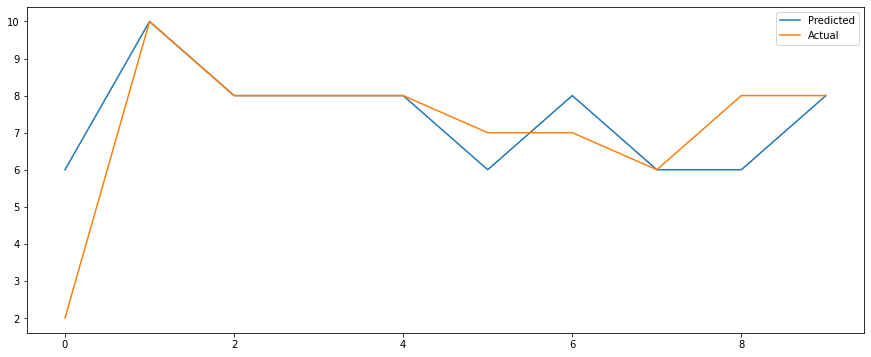

In [54]:
%pylab inline 
pylab.rcParams['figure.figsize'] = (15,6)
plt.plot(result3[:10],label = 'Predicted')
plt.plot(Y_test[:10].values, label = 'Actual')

plt.legend()
plt.show()

## Logistic Regression
Considering the limitation of processor, so I take max_iterarion is 30000.<br>
max_iter() : Maximum number of iterations taken for the solvers to converge.

In [55]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=30000).fit(pred, Y_train)
result2 = logreg.predict(pred1)
result2[:5]

array([ 6., 10.,  8.,  8., 10.])

In [89]:
logreg_score = accuracy_score(Y_test, result2)
logreg_rmse = mean_squared_error(Y_test, result2)
print("Accuracy:   {:.5f}".format(logreg_score))
print("MSE:   {:.5f}".format(logreg_rmse))
print("Classification Report for Logistic Regression:\n", classification_report(Y_test,result2))

Accuracy:   0.29304
MSE:   2.97676
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

         1.0       0.24      0.10      0.15       338
         2.0       0.18      0.07      0.11       659
         3.0       0.13      0.06      0.08      1147
         4.0       0.20      0.10      0.13      2319
         5.0       0.19      0.10      0.13      3579
         6.0       0.29      0.32      0.31      8867
         7.0       0.28      0.28      0.28      9727
         8.0       0.33      0.52      0.40     11339
         9.0       0.23      0.11      0.15      4155
        10.0       0.34      0.20      0.26      2796

    accuracy                           0.29     44926
   macro avg       0.24      0.19      0.20     44926
weighted avg       0.28      0.29      0.27     44926



In [57]:
print("Training set score: {:.5f}".format(logreg.score(pred, Y_train)))
print("Test set score: {:.5f}".format(logreg.score(pred1, Y_test)))

Training set score: 0.52512
Test set score: 0.29304


Populating the interactive namespace from numpy and matplotlib


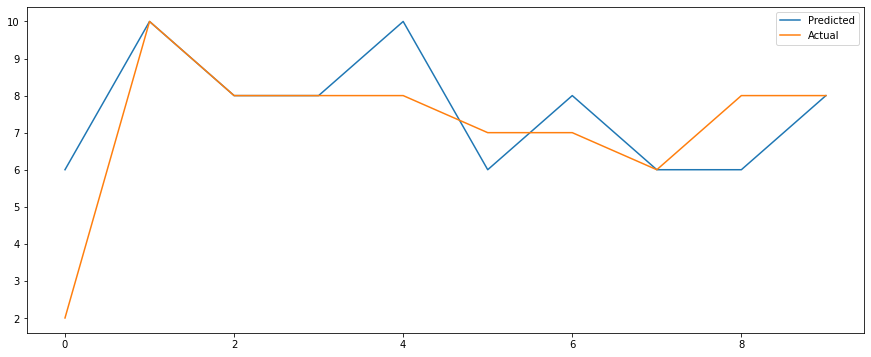

In [58]:
%pylab inline 
pylab.rcParams['figure.figsize'] = (15,6)
plt.plot(result2[:10],label = 'Predicted')
plt.plot(Y_test[:10].values, label = 'Actual')

plt.legend()
plt.show()

In [59]:
# from sklearn.model_selection import GridSearchCV
# param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
# grid = GridSearchCV(LogisticRegression(max_iter=20000), param_grid, cv=5)
# grid.fit(pred, Y_train)

<b> Logistic Regression with tfidf </b>

In [60]:
result5 = logreg.predict(predtf1)
result5[:5]

array([6., 7., 8., 8., 8.])

In [90]:
logreg_score2 = accuracy_score(Y_test, result5)
logreg2_rmse = mean_squared_error(Y_test, result5)
print("Accuracy:   {:.5f}".format(logreg_score2))
print("MSE:   {:.5f}".format(logreg2_rmse))
print("Classification Report for Logistic regression with tf-idf:\n", classification_report(Y_test,result5))

Accuracy:   0.28556
MSE:   3.10695
Classification Report for Logistic regression with tf-idf:
               precision    recall  f1-score   support

         1.0       1.00      0.00      0.01       338
         2.0       0.00      0.00      0.00       659
         3.0       0.29      0.00      0.00      1147
         4.0       0.25      0.01      0.01      2319
         5.0       0.20      0.01      0.02      3579
         6.0       0.28      0.31      0.29      8867
         7.0       0.25      0.28      0.27      9727
         8.0       0.31      0.64      0.41     11339
         9.0       0.28      0.00      0.01      4155
        10.0       0.65      0.01      0.01      2796

    accuracy                           0.29     44926
   macro avg       0.35      0.13      0.10     44926
weighted avg       0.30      0.29      0.22     44926



In [62]:
print("Training set score: {:.5f}".format(logreg.score(predtf, Y_train)))
print("Test set score: {:.5f}".format(logreg.score(predtf1, Y_test)))

Training set score: 0.41381
Test set score: 0.28556


Populating the interactive namespace from numpy and matplotlib


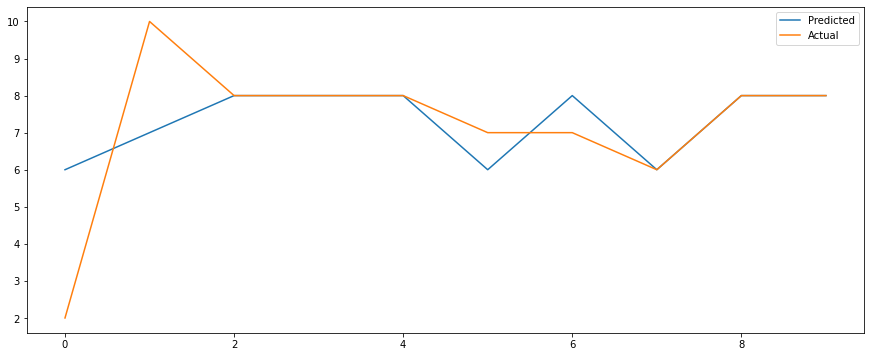

In [63]:
%pylab inline 
pylab.rcParams['figure.figsize'] = (15,6)
plt.plot(result5[:10],label = 'Predicted')
plt.plot(Y_test[:10].values, label = 'Actual')

plt.legend()
plt.show()

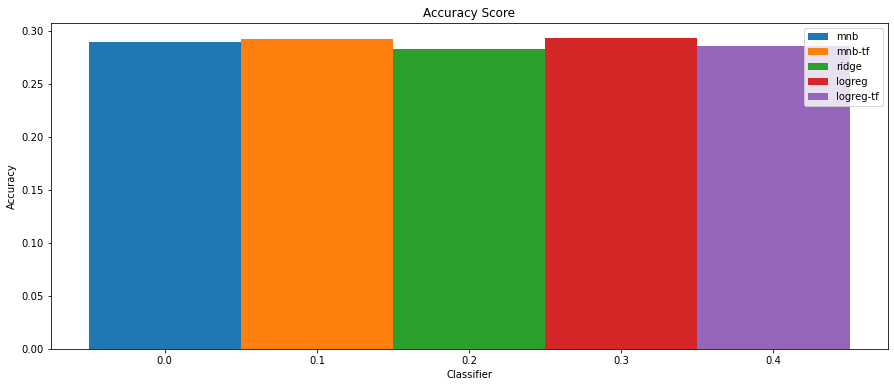

In [64]:
N=1
imp=np.arange(N)
width=0.1
plt.bar(imp, mnb_score , width,label='mnb')
plt.bar(imp+width, mnb_score2 , width,label='mnb-tf')
plt.bar(imp+width+width, ridge_score , width,label='ridge')
plt.bar(imp+width+width+width, logreg_score , width,label='logreg')
plt.bar(imp+width+width+width+width, logreg_score2 , width,label='logreg-tf')
plt.ylabel('Accuracy')
plt.xlabel('Classifier')
plt.title('Accuracy Score')
plt.legend(loc='best')
plt.show()

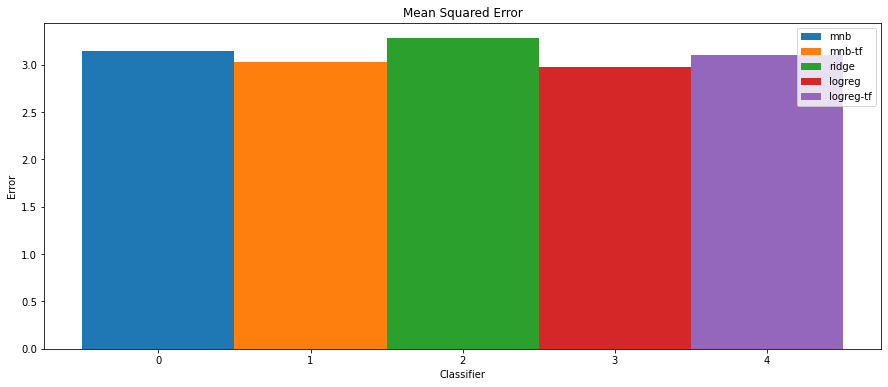

In [65]:
N=1
imp=np.arange(N)
width=1
plt.bar(imp, mnb_rmse , width,label='mnb')
plt.bar(imp+width, mnb_rmse2 , width,label='mnb-tf')
plt.bar(imp+width+width, ridge_rmse , width,label='ridge')
plt.bar(imp+width+width+width, logreg_rmse , width,label='logreg')
plt.bar(imp+width+width+width+width, logreg2_rmse , width,label='logreg-tf')
plt.ylabel('Error')
plt.xlabel('Classifier')
plt.title('Mean Squared Error')
plt.legend(loc='best')
plt.show()

### Final Observation
Considering Accuracy and Mean Squared Error, Multinomial Naive Bayes with tfidf and logistic Regression performs very good and gives reasonable accuracy.

### FInal Test
The model did a good job of predicting rating for the input.

In [97]:
my_comment = ['worst game']
my_vectorizer = vectorizer.transform(my_comment)
my_prediction = logreg.predict(my_vectorizer)
print('Game Rating is :',(my_prediction[0]))

Game Rating is : 1.0


In [98]:
my_comment = ['Excellent game with good background music']
my_vectorizer = vectorizer.transform(my_comment)
my_prediction = mnb.predict(my_vectorizer)
print('Game Rating is :',(my_prediction[0]))

Game Rating is : 9.0


### <b> Improvements and Contribution </b>
Most of the existing review classifier have take accuracy as a hyperparameter tuning, but I take accuracy and mean squared error as well for better accuracy.<br><br>
I test all the classifier with Countvectorizer and Tfidfvectorizer as well to compare the results.<br>
I find that TfidfVectorizer gives better result with multinomial naive bayes and Countvectorizer gives better result with logistic regression.<br><br>
I also used GridsearchCV to find optimal alpha values which gives better accuracy.<br><br>
It is observed that RidgeClassifier and Multinomial Naive Bayes are faster compare to Linear Regression.

### <b> Challenges </b>
There are Numerous different values for rating in dataset, it is very hard to classify with that much of different values. So I used round() method from numpy to roundof the values.<br><br>
The dataset is very large for the system I used, So first I have to preprocess the data and then took 5% of data for classification.<br><br>

### References:
1.https://github.com/jeremygrace/amazon-reviews/blob/master/sentiment-topic_modeling/Amazon_Reviews.ipynb as a reference<br>
2.https://github.com/mansipatel2508/Yelp-Review-Stars-Prediction-with-Machine-Learning/blob/master/Yelp_Business_Stars%E2%80%99_Rating_Prediction.ipynb as a reference<br>
3.https://github.com/rajat-1994/news-classifier/blob/master/news_classifier.ipynb as a reference<br>
4.https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html for GridSearchcv <br>
5.https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html for accuracy score<br>
6.https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html for classification report<br>
7.https://pythonhealthcare.org/2018/12/14/101-pre-processing-data-tokenization-stemming-and-removal-of-stop-words/ for preprocess the data <br>
8.https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html for tfidfvectorizer<br>
9.https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html and https://stackoverflow.com/questions/57085897/python-logistic-regression-max-iter-parameter-is-reducing-the-accuracy for logistic regression<br>
10.<b> For Flask App</b>: I have used my one module, which was provided by one of my previous semester subject's Professor Dr. Devid Levine.

### <b> Links:</b>
App : http://jemis43992.mybluemix.net/ <br>
You tube Video: https://www.youtube.com/watch?v=NNfqphQWqXw <br>
Github : https://github.com/jemis4991/Data-Mining-Term-Project <br>
PortFolio : http://jpd3032.uta.cloud/portfolio/ <br>
Blog : http://jpd3032.uta.cloud/blog-dm/
-http://jpd3032.uta.cloud/portfolio/Term-Project.html